# Explain diamonds model

The aim of this notebook is to model diamond prices with optimized Gradient Boosting and then explain the resulting model by [SHAP](https://github.com/slundberg/shap), a concept borrowed from game theory. As such, the notebook can be used as a template for other regression situations.

## Load libraries and data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-notebook')
sns.set(context="notebook", style="whitegrid")

diamonds = sns.load_dataset("diamonds")
print("The first lines of the data set:", diamonds.head(), sep="\n")

The first lines of the data set:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


## Transform data

Before describing the data, we apply some transformations:

- Clipping extreme values for depth, and table

- Reordering levels of categorical columns (color, cut, clarity)

- Log transformation of the response "price" and carat.

In [32]:
from pandas.api.types import CategoricalDtype

# Function that prepares a pandas df line by line
#  -> handling of categories looks too verbose but allows (A) for safe preparation of a single line
#     and (B) for the right ordering of levels.

def transform(df):
    df = df.assign(log_price=np.log(df.price),
                   log_carat=np.log(df.carat),
                   depth=df.depth.clip(55, 70),
                   table=df.table.clip(50, 70),
                   color=pd.Categorical(df.color, categories=['D', 'E', 'F', 'G', 'H', 'I', 'J']),
                   cut=pd.Categorical(df.cut, categories=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']),
                   clarity=pd.Categorical(df.clarity, categories=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']))
    return df.drop(list("xyz"), axis=1)

df = transform(diamonds)

# Important variable groups
response = "log_price"
num_vars = ["log_carat", "depth", "table"]
ordinal_vars = ["color", "cut", "clarity"]
features = num_vars + ordinal_vars

## Describe data

### Univariate categorical variables

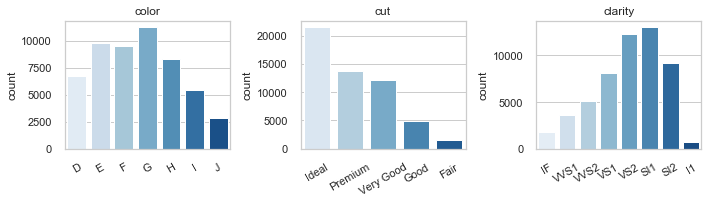

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i, v in enumerate(ordinal_vars):
    sns.countplot(df[v], palette="Blues", ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)
    ax[i].set_xlabel("")
fig.tight_layout()

### Univariate numeric variables

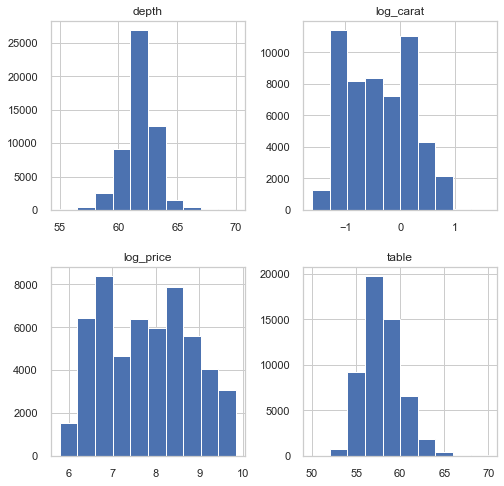

In [34]:
df[[response] + num_vars].hist(figsize=(8, 8), layout=(2, 2));

### Associations across numerics (incl. response)

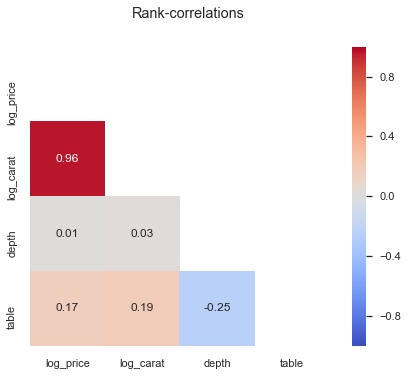

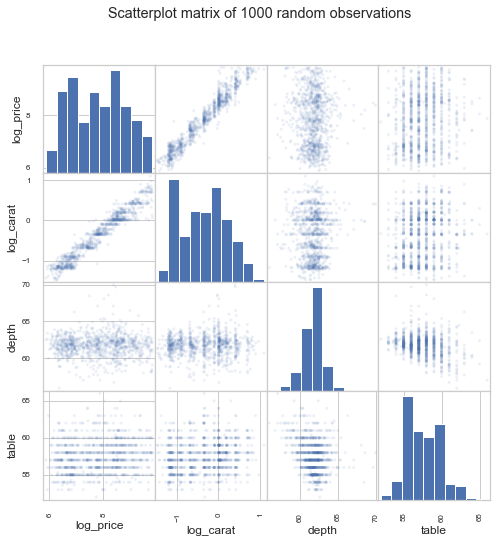

In [35]:
# Correlations
corrmat = df[[response] + num_vars].corr("spearman")
sns.heatmap(corrmat, center=0, vmin=-1, vmax=1, 
            cmap='coolwarm', annot=True, square=True,
            mask=np.triu(corrmat));
plt.suptitle('Rank-correlations')
plt.show()

# Scatter
pd.plotting.scatter_matrix(df[[response] + num_vars].sample(1000), alpha=0.1, figsize=(8, 8));
plt.suptitle('Scatterplot matrix of 1000 random observations')
plt.show()

### Associations between categorical covariables and response

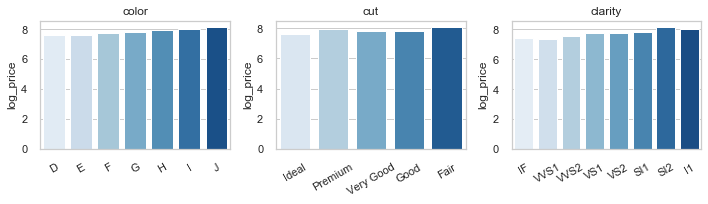

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i, v in enumerate(ordinal_vars):
    sns.barplot(x=v, y=response, data=df, palette="Blues", ax=ax[i], ci=None)
    ax[i].set_title(v)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)
    ax[i].set_xlabel("")
fig.tight_layout()

The relationships seem the wrong way around: The better a characteristic, the lower the price. This phenomenon will vanish as soon as taking into account the size of the stones, see the last part of the notebook.

### Missing values

In [37]:
df[[response] + features].isna().sum().sort_values(ascending=False)

clarity      0
cut          0
color        0
table        0
depth        0
log_carat    0
log_price    0
dtype: int64

## Prepare data for modeling

We will model the response by [LightGBM](https://github.com/microsoft/LightGBM), an extremely fast, open source gradient boosting implementation by Microsoft. Since its data interface allows only numeric columns, we replace categorical variables by their order index. For interpreting the models, we keep a version of the data with the original, human readable codings.

In [38]:
# Safe way to do integer coding with Pandas
def ordinalCoder(df):
    df = df.copy()
    cats = df.select_dtypes("category").columns
    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    return df
    
# Response & features
y = df[response]
X_display = df[features]

# Integer coding
X = ordinalCoder(X_display)

print("Data structure for model:", X.head(), sep="\n")
print("\nData structure for interpretation:", X_display.head(), sep="\n")

Data structure for model:
   log_carat  depth  table  color  cut  clarity
0  -1.469676   61.5   55.0      1    0        6
1  -1.560648   59.8   61.0      1    1        5
2  -1.469676   56.9   65.0      1    3        3
3  -1.237874   62.4   58.0      5    1        4
4  -1.171183   63.3   58.0      6    3        6

Data structure for interpretation:
   log_carat  depth  table color      cut clarity
0  -1.469676   61.5   55.0     E    Ideal     SI2
1  -1.560648   59.8   61.0     E  Premium     SI1
2  -1.469676   56.9   65.0     E     Good     VS1
3  -1.237874   62.4   58.0     I  Premium     VS2
4  -1.171183   63.3   58.0     J     Good     SI2


### Check preprocessing pipeline

In order to release a model in a (web-)service, it is of major importance to build a save preprocessing pipeline working also for single observations. In our case, this basically means to not mess up with wrong codings of categories.

In [39]:
step1 = transform(diamonds.head(1))
print("\nAfter transformations:\n", step1)
print("\nAfter integer codings:\n", ordinalCoder(step1))


After transformations:
    carat    cut color clarity  depth  table  price  log_price  log_carat
0   0.23  Ideal     E     SI2   61.5   55.0    326   5.786897  -1.469676

After integer codings:
    carat  cut  color  clarity  depth  table  price  log_price  log_carat
0   0.23    0      1        6   61.5   55.0    326   5.786897  -1.469676


## Modeling

We now model the response as good as possible by the prepared features. For this purpose, we use a Gradient Boosting approach. Parameters are selected by iterative GridSearch with five-fold crossvalidation on 80% training data. The final model is then evaluated on the remaining 20% test data and compared with a Random Forest baseline model. Ideally, the tuned boosted trees do better than this benchmark. 

The models are fitted by optimizing L2 loss.

We start by splitting the data into train and test.

### Data split

In [40]:
# Data split
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# create a train/test split
X_display_train, X_display_test, X_train, X_test, y_train, y_test = train_test_split(
    X_display, X, y, test_size=0.2, random_state=7, shuffle=True)

dtrain = lgb.Dataset(X_train, 
                     label=y_train, 
                     free_raw_data=False)

### Tune model

In [43]:
tune = False

if tune:
    from sklearn.model_selection import ParameterSampler, ParameterGrid
    
    # Final narrow grid
    grid = ParameterSampler({
        "learning_rate": [0.02],
        "num_leaves": [20, 30, 40],
        'min_child_samples': [10, 15, 20],
        'reg_alpha': [0, 1, 2],
        'reg_lambda': [0, 1],
        'min_split_gain': [0, 0.001],
        'subsample': [0.9, 1],
        'bagging_freq': [1],
        'colsample_bytree': [1],
        'colsample_bynode': [1],
        "verbose": [2],
        "objective": ["regression_l2"],
        "metric": ["rmse"],
        "nthread": [8] 
    }, n_iter=10)
    
    gridsearch_results = pd.DataFrame(columns=["params", "num_boost_round", "perf"])

    print("We are iterating through grid of size", len(grid))
    for g in grid:
        cv_results = lgb.cv(
            g,
            dtrain,
            num_boost_round=10000,
            nfold=5,
            stratified=False,
            early_stopping_rounds=20)
        perf = cv_results['rmse-mean']
        new_row = {"params": [g], "num_boost_round": len(perf), "perf": perf[-1]}
        print(new_row)
        gridsearch_results = gridsearch_results.append(new_row, ignore_index=True)  
        gridsearch_results.to_json("gridsearch_diamonds.txt")


We are iterating through grid of size 10
{'params': [{'verbose': 2, 'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'regression_l2', 'num_leaves': 40, 'nthread': 8, 'min_split_gain': 0, 'min_child_samples': 10, 'metric': 'rmse', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}], 'num_boost_round': 1301, 'perf': 0.09643249308971925}
{'params': [{'verbose': 2, 'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'regression_l2', 'num_leaves': 30, 'nthread': 8, 'min_split_gain': 0, 'min_child_samples': 15, 'metric': 'rmse', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}], 'num_boost_round': 2170, 'perf': 0.09629600164546495}
{'params': [{'verbose': 2, 'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 2, 'objective': 'regression_l2', 'num_leaves': 30, 'nthread': 8, 'min_split_gain': 0.001, 'min_child_samples': 15, 'metric': 'rmse', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_

### Load best grid

In [44]:
gridsearch_results = pd.read_json("gridsearch_diamonds.txt")
gridsearch_results.sort_values("perf", inplace=True)
gridsearch_results.head()

params  num_boost_round  \
1  [{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...             2170   
8  [{'verbose': 2, 'subsample': 1, 'reg_lambda': ...             1781   
0  [{'verbose': 2, 'subsample': 1, 'reg_lambda': ...             1301   
7  [{'verbose': 2, 'subsample': 1, 'reg_lambda': ...             1409   
4  [{'verbose': 2, 'subsample': 0.9, 'reg_lambda'...             2751   

       perf  
1  0.096296  
8  0.096391  
0  0.096432  
7  0.096527  
4  0.096534

### Fit model

In [45]:
best = gridsearch_results.iloc[0]
print("Best parameter choice", best.params[0], sep="\n")
model = lgb.train(best.params[0], dtrain, num_boost_round=best.num_boost_round)

Best parameter choice
{'verbose': 2, 'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'regression_l2', 'num_leaves': 30, 'nthread': 8, 'min_split_gain': 0, 'min_child_samples': 15, 'metric': 'rmse', 'learning_rate': 0.02, 'colsample_bytree': 1, 'colsample_bynode': 1, 'bagging_freq': 1}


### Performance

To assess model performance, we study the scoring function used for optimization, namely the root mean-squared error on the log price scale.

In [49]:
from sklearn.metrics import mean_squared_error as mse
def rmse(y, pred):
    return np.sqrt(mse(y, pred))

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [51]:
print("Training RMSE: {:.4f}".format(rmse(y_train, pred_train)))
print("Test RMSE: {:.4f}".format(rmse(y_test, pred_test)))

Training RMSE: 0.0894
Test RMSE: 0.0945


Compared to a random forest benchmark:

In [52]:
# Compare with RF
rf = RandomForestRegressor(500, n_jobs=8)
rf.fit(X_train, y_train)
pred_test_rf = rf.predict(X_test)

In [53]:
print("Test RMSE for Random Forest: {:.4f}".format(rmse(y_test, pred_test_rf)))

Test RMSE for Random Forest: 0.1082


The tuned model does considerably better than the random forest. Overfitting is present and will impact the following SHAP analysis.

## Explain model

For model interpretation, we use [SHAP](https://github.com/slundberg/shap). The idea of SHAP is to decompose single predictions into additive contributions from features as fair as possible. From these decompositions, variable importance and effects can be derived for free.

In [54]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Number of SHAP decompositions
N_SHAP = 2000 

# Initialize tree explainer
explainer = shap.TreeExplainer(model)

# Calculate N_SHAP decompositions
shap_values = explainer.shap_values(X_train[:N_SHAP])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Illustration

For illustration of SHAP, we now decompose the prediction of the first observation into its SHAP components.

The original observation
log_carat    0.727549
depth            61.8
table              61
color               I
cut              Good
clarity           VS2
Name: 27682, dtype: object

The prediction walk


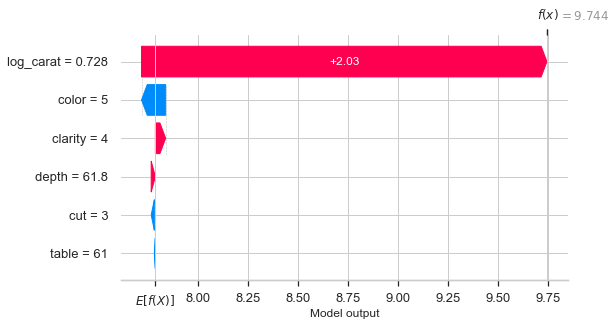


The expected value: 7.787051357039187


In [56]:
print("The original observation", X_display_train.iloc[0], sep="\n")
print("\nThe prediction walk")

shap.waterfall_plot(explainer.expected_value, shap_values[0], features=X_train.iloc[0])

print("\nThe expected value:", explainer.expected_value)

The waterfall plot is read from bottom to top: Starting with an expected value of about 7.79 log USD, the prediction is negatively impacted by its bad color. Thanks to its whopping size, the prediction is heavily increased.

### Variable importance

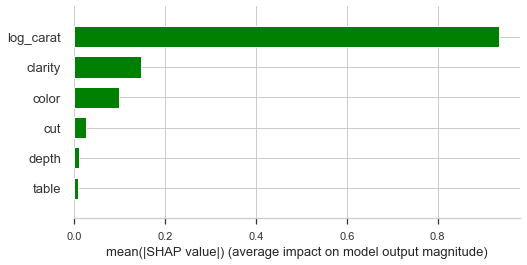

In [57]:
shap.summary_plot(shap_values, X_train[:N_SHAP], plot_type="bar", color="Green")

Not surprisingly, the most important feature is the size, followed by clarity and color.

### Effects plots

To get an impression on the effect of a feature $X$, we plot all contributions of $X$ against $X$. They are on the centered response scale.

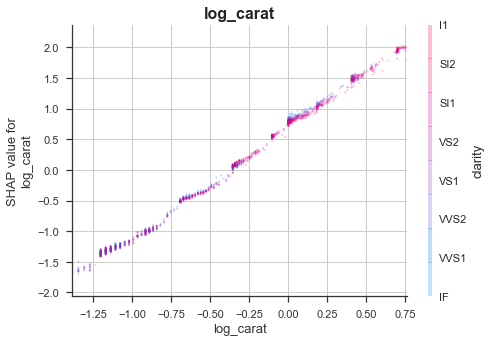

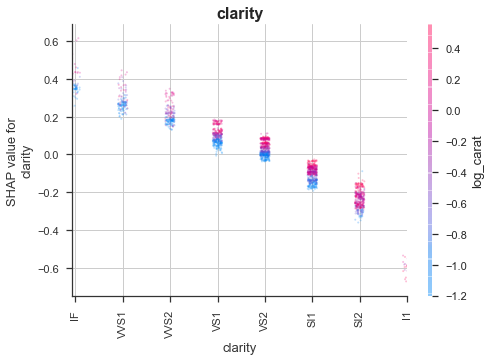

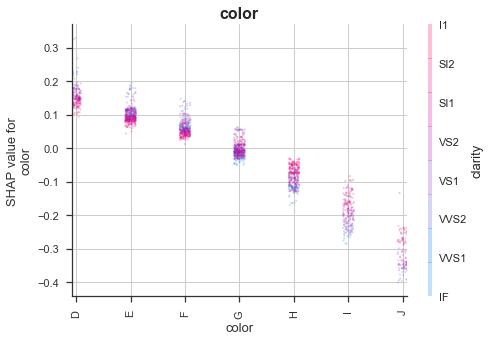

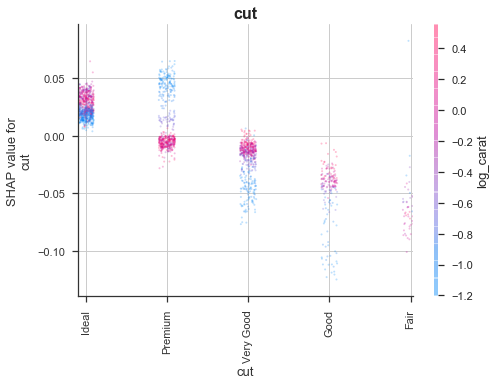

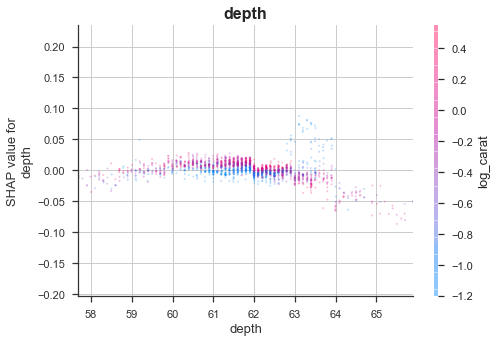

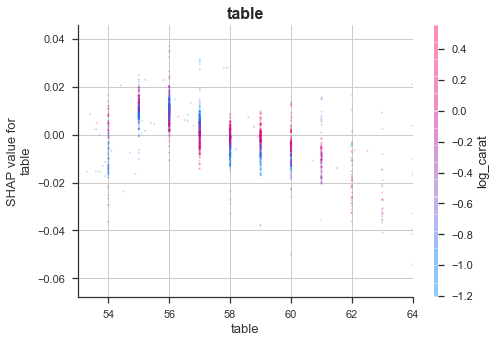

In [58]:
sorted_cols = X_train.columns[np.argsort(-np.abs(shap_values).mean(0))]

for name in sorted_cols:
    shap.dependence_plot(name, shap_values, # + explainer.expected_value, 
                         X_train[:N_SHAP], display_features=X_display_train[:N_SHAP], 
                         show=False, alpha=0.25, dot_size=4, x_jitter=0.2, 
                         xmin="percentile(1)", xmax="percentile(99)")
    plt.title(f"{name}", fontdict={'fontsize': 16, 'weight': 'bold'})
    plt.show()